In [1]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"beckoliver","key":"556415c0977bbabf21459dcd522412f9"}'}

In [2]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

In [3]:
! kaggle datasets download -d manideep1108/tusimple

100% 21.6G/21.6G [16:07<00:00, 31.3MB/s]
100% 21.6G/21.6G [16:07<00:00, 24.0MB/s]


In [ ]:
! unzip tusimple.zip

In [ ]:
import json
import os
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import numpy as np
import tqdm
import seaborn as sns
import torch
import torch.nn as nn
from torch.nn.modules.loss import _Loss
from torch.autograd import Variable
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import transforms
from torch.utils.data.sampler import SubsetRandomSampler
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

import warnings
warnings.filterwarnings("ignore")

In [6]:
class LaneDataset(torch.utils.data.Dataset):
    def __init__(self, dataset_path="/content/TUSimple/train_set", train=True, size=(512, 256)):
        self._dataset_path = dataset_path
        self._mode = "train" if train else "eval"
        self._image_size = size # w, h


        if self._mode == "train":
            label_files = [
                os.path.join(self._dataset_path, f"label_data_{suffix}.json")
                for suffix in ("0313", "0531")
            ]
        elif self._mode == "eval":
            label_files = [
                os.path.join(self._dataset_path, f"label_data_{suffix}.json")
                for suffix in ("0601",)
            ]

        self._data = []

        for label_file in label_files:
            self._process_label_file(label_file)

    def __getitem__(self, idx):
        image_path = os.path.join(self._dataset_path, self._data[idx][0])
        image = cv2.imread(image_path)
        h, w, c = image.shape
        raw_image = image
        image = cv2.resize(image, self._image_size, interpolation=cv2.INTER_LINEAR)

        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        image = image[..., None]
        lanes = self._data[idx][1]

        segmentation_image = self._draw(h, w, lanes, "segmentation")
        instance_image = self._draw(h, w, lanes, "instance")

        instance_image = instance_image[..., None]

        image = torch.from_numpy(image).float().permute((2, 0, 1))
        segmentation_image = torch.from_numpy(segmentation_image.copy())
        instance_image =  torch.from_numpy(instance_image.copy()).permute((2, 0, 1))
        segmentation_image = segmentation_image.to(torch.int64)

        return image, segmentation_image, instance_image, raw_image # 1 x H x W [[0, 1], [2, 0]]

    def __len__(self):
        return len(self._data)

    def _draw(self, h, w, lanes, image_type):
        image = np.zeros((h, w), dtype=np.uint8)
        for i, lane in enumerate(lanes):
            color = 1 if image_type == "segmentation" else i + 1
            cv2.polylines(image, [lane], False, color, 10)

        image = cv2.resize(image, self._image_size, interpolation=cv2.INTER_NEAREST)

        return image

    def _process_label_file(self, file_path):
        with open(file_path) as f:
            for line in f:
                info = json.loads(line)
                image = info["raw_file"]
                lanes = info["lanes"]
                h_samples = info["h_samples"]
                lanes_coords = []
                for lane in lanes:
                    x = np.array([lane]).T
                    y = np.array([h_samples]).T
                    xy = np.hstack((x, y))
                    idx = np.where(xy[:, 0] > 0)
                    lane_coords = xy[idx]
                    lanes_coords.append(lane_coords)
                self._data.append((image, lanes_coords))

    def _show_images_examples( self , number_sample = 10 ):

        sns.set_theme()

        f, axarr = plt.subplots( number_sample   ,2 , figsize = ( 20 , 30 ))

        plt.axis('off')

        for i in range( number_sample ):

            axarr[ i , 0].imshow(  self.__getitem__( idx = i )[ 3 ].reshape( 720 , 1280 , 3)  )
            axarr[ i , 0 ].set_title( "Lane Image Data No " + str( i + 1) )
            axarr[ i , 0 ].set_axis_off()

            axarr[ i , 1 ].imshow(  self.__getitem__( idx = i )[ 2 ].reshape( self._image_size ) )
            axarr[ i , 1 ].set_title( "Lane Image Segmentation Data No " + str( i + 1) )
            axarr[ i , 1 ].set_axis_off()

        f.tight_layout()
        plt.show()

In [7]:
class InitialBlock(nn.Module):
    def __init__(self,
                 in_channels,
                 out_channels,
                 bias=False,
                 relu=True):
        super().__init__()

        if relu:
            activation = nn.ReLU
        else:
            activation = nn.PReLU

        self.main_branch = nn.Conv2d(
            in_channels,
            out_channels - 1,
            kernel_size=3,
            stride=2,
            padding=1,
            bias=bias)

        self.ext_branch = nn.MaxPool2d(3, stride=2, padding=1)

        self.batch_norm = nn.BatchNorm2d(out_channels)
        self.out_activation = activation()

    def forward(self, x):
        main = self.main_branch(x)
        ext = self.ext_branch(x)

        out = torch.cat((main, ext), 1)

        out = self.batch_norm(out)

        return self.out_activation(out)


class RegularBottleneck(nn.Module):
    def __init__(self,
                 channels,
                 internal_ratio=4,
                 kernel_size=3,
                 padding=0,
                 dilation=1,
                 asymmetric=False,
                 dropout_prob=0,
                 bias=False,
                 relu=True):
        super().__init__()

        if internal_ratio <= 1 or internal_ratio > channels:
            raise RuntimeError("Value out of range. Expected value in the "
                               "interval [1, {0}], got internal_scale={1}."
                               .format(channels, internal_ratio))

        internal_channels = channels // internal_ratio

        if relu:
            activation = nn.ReLU
        else:
            activation = nn.PReLU


        self.ext_conv1 = nn.Sequential(
            nn.Conv2d(
                channels,
                internal_channels,
                kernel_size=1,
                stride=1,
                bias=bias), nn.BatchNorm2d(internal_channels), activation())

        if asymmetric:
            self.ext_conv2 = nn.Sequential(
                nn.Conv2d(
                    internal_channels,
                    internal_channels,
                    kernel_size=(kernel_size, 1),
                    stride=1,
                    padding=(padding, 0),
                    dilation=dilation,
                    bias=bias), nn.BatchNorm2d(internal_channels), activation(),
                nn.Conv2d(
                    internal_channels,
                    internal_channels,
                    kernel_size=(1, kernel_size),
                    stride=1,
                    padding=(0, padding),
                    dilation=dilation,
                    bias=bias), nn.BatchNorm2d(internal_channels), activation())
        else:
            self.ext_conv2 = nn.Sequential(
                nn.Conv2d(
                    internal_channels,
                    internal_channels,
                    kernel_size=kernel_size,
                    stride=1,
                    padding=padding,
                    dilation=dilation,
                    bias=bias), nn.BatchNorm2d(internal_channels), activation())


        self.ext_conv3 = nn.Sequential(
            nn.Conv2d(
                internal_channels,
                channels,
                kernel_size=1,
                stride=1,
                bias=bias), nn.BatchNorm2d(channels), activation())

        self.ext_regul = nn.Dropout2d(p=dropout_prob)


        self.out_activation = activation()

    def forward(self, x):
        main = x

        ext = self.ext_conv1(x)
        ext = self.ext_conv2(ext)
        ext = self.ext_conv3(ext)
        ext = self.ext_regul(ext)

        out = main + ext

        return self.out_activation(out)


In [8]:
class DownsamplingBottleneck(nn.Module):
    def __init__(self,
                 in_channels,
                 out_channels,
                 internal_ratio=4,
                 return_indices=False,
                 dropout_prob=0,
                 bias=False,
                 relu=True):
        super().__init__()

        self.return_indices = return_indices

        if internal_ratio <= 1 or internal_ratio > in_channels:
            raise RuntimeError("Value out of range. Expected value in the "
                               "interval [1, {0}], got internal_scale={1}. "
                               .format(in_channels, internal_ratio))

        internal_channels = in_channels // internal_ratio

        if relu:
            activation = nn.ReLU
        else:
            activation = nn.PReLU

        self.main_max1 = nn.MaxPool2d(
            2,
            stride=2,
            return_indices=return_indices)

        self.ext_conv1 = nn.Sequential(
            nn.Conv2d(
                in_channels,
                internal_channels,
                kernel_size=2,
                stride=2,
                bias=bias), nn.BatchNorm2d(internal_channels), activation())

        self.ext_conv2 = nn.Sequential(
            nn.Conv2d(
                internal_channels,
                internal_channels,
                kernel_size=3,
                stride=1,
                padding=1,
                bias=bias), nn.BatchNorm2d(internal_channels), activation())

        self.ext_conv3 = nn.Sequential(
            nn.Conv2d(
                internal_channels,
                out_channels,
                kernel_size=1,
                stride=1,
                bias=bias), nn.BatchNorm2d(out_channels), activation())

        self.ext_regul = nn.Dropout2d(p=dropout_prob)

        self.out_activation = activation()

    def forward(self, x):
        if self.return_indices:
            main, max_indices = self.main_max1(x)
        else:
            main = self.main_max1(x)

        ext = self.ext_conv1(x)
        ext = self.ext_conv2(ext)
        ext = self.ext_conv3(ext)
        ext = self.ext_regul(ext)

        n, ch_ext, h, w = ext.size()
        ch_main = main.size()[1]
        padding = torch.zeros(n, ch_ext - ch_main, h, w)

        if main.is_cuda:
            padding = padding.cuda()

        main = torch.cat((main, padding), 1)

        out = main + ext

        return self.out_activation(out), max_indices

In [9]:
class UpsamplingBottleneck(nn.Module):
    def __init__(self,
                 in_channels,
                 out_channels,
                 internal_ratio=4,
                 dropout_prob=0,
                 bias=False,
                 relu=True):
        super().__init__()

        if internal_ratio <= 1 or internal_ratio > in_channels:
            raise RuntimeError("Value out of range. Expected value in the "
                               "interval [1, {0}], got internal_scale={1}. "
                               .format(in_channels, internal_ratio))

        internal_channels = in_channels // internal_ratio

        if relu:
            activation = nn.ReLU
        else:
            activation = nn.PReLU

        self.main_conv1 = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=1, bias=bias),
            nn.BatchNorm2d(out_channels))

        self.main_unpool1 = nn.MaxUnpool2d(kernel_size=2)

        self.ext_conv1 = nn.Sequential(
            nn.Conv2d(
                in_channels, internal_channels, kernel_size=1, bias=bias),
            nn.BatchNorm2d(internal_channels), activation())

        self.ext_tconv1 = nn.ConvTranspose2d(
            internal_channels,
            internal_channels,
            kernel_size=2,
            stride=2,
            bias=bias)
        self.ext_tconv1_bnorm = nn.BatchNorm2d(internal_channels)
        self.ext_tconv1_activation = activation()

        self.ext_conv2 = nn.Sequential(
            nn.Conv2d(
                internal_channels, out_channels, kernel_size=1, bias=bias),
            nn.BatchNorm2d(out_channels), activation())

        self.ext_regul = nn.Dropout2d(p=dropout_prob)

        self.out_activation = activation()

    def forward(self, x, max_indices, output_size):
        main = self.main_conv1(x)
        main = self.main_unpool1(
            main, max_indices, output_size=output_size)

        ext = self.ext_conv1(x)
        ext = self.ext_tconv1(ext, output_size=output_size)
        ext = self.ext_tconv1_bnorm(ext)
        ext = self.ext_tconv1_activation(ext)
        ext = self.ext_conv2(ext)
        ext = self.ext_regul(ext)

        out = main + ext

        return self.out_activation(out)


In [10]:

class UNet(nn.Module):
    def __init__(self, binary_seg, embedding_dim, encoder_relu=False, decoder_relu=True):
        super(UNet, self).__init__()

        self.initial_block = InitialBlock(1, 16, relu=encoder_relu)

        self.downsample1_0 = DownsamplingBottleneck(16, 64, return_indices=True, dropout_prob=0.01, relu=encoder_relu)
        self.regular1_1 = RegularBottleneck(64, padding=1, dropout_prob=0.01, relu=encoder_relu)
        self.regular1_2 = RegularBottleneck(64, padding=1, dropout_prob=0.01, relu=encoder_relu)
        self.regular1_3 = RegularBottleneck(64, padding=1, dropout_prob=0.01, relu=encoder_relu)
        self.regular1_4 = RegularBottleneck(64, padding=1, dropout_prob=0.01, relu=encoder_relu)

        self.downsample2_0 = DownsamplingBottleneck(64, 128, return_indices=True, dropout_prob=0.1, relu=encoder_relu)
        self.regular2_1 = RegularBottleneck(128, padding=1, dropout_prob=0.1, relu=encoder_relu)
        self.dilated2_2 = RegularBottleneck(128, dilation=2, padding=2, dropout_prob=0.1, relu=encoder_relu)
        self.asymmetric2_3 = RegularBottleneck(128, kernel_size=5, padding=2, asymmetric=True, dropout_prob=0.1, relu=encoder_relu)
        self.dilated2_4 = RegularBottleneck(128, dilation=4, padding=4, dropout_prob=0.1, relu=encoder_relu)
        self.regular2_5 = RegularBottleneck(128, padding=1, dropout_prob=0.1, relu=encoder_relu)
        self.dilated2_6 = RegularBottleneck(128, dilation=8, padding=8, dropout_prob=0.1, relu=encoder_relu)
        self.asymmetric2_7 = RegularBottleneck(128, kernel_size=5, asymmetric=True, padding=2, dropout_prob=0.1, relu=encoder_relu)
        self.dilated2_8 = RegularBottleneck(128, dilation=16, padding=16, dropout_prob=0.1, relu=encoder_relu)

        self.regular_binary_3_0 = RegularBottleneck(128, padding=1, dropout_prob=0.1, relu=encoder_relu)
        self.dilated_binary_3_1 = RegularBottleneck(128, dilation=2, padding=2, dropout_prob=0.1, relu=encoder_relu)
        self.asymmetric_binary_3_2 = RegularBottleneck(128, kernel_size=5, padding=2, asymmetric=True, dropout_prob=0.1, relu=encoder_relu)
        self.dilated_binary_3_3 = RegularBottleneck(128, dilation=4, padding=4, dropout_prob=0.1, relu=encoder_relu)
        self.regular_binary_3_4 = RegularBottleneck(128, padding=1, dropout_prob=0.1, relu=encoder_relu)
        self.dilated_binary_3_5 = RegularBottleneck(128, dilation=8, padding=8, dropout_prob=0.1, relu=encoder_relu)
        self.asymmetric_binary_3_6 = RegularBottleneck(128, kernel_size=5, asymmetric=True, padding=2, dropout_prob=0.1, relu=encoder_relu)
        self.dilated_binary_3_7 = RegularBottleneck(128, dilation=16, padding=16, dropout_prob=0.1, relu=encoder_relu)

        self.regular_embedding_3_0 = RegularBottleneck(128, padding=1, dropout_prob=0.1, relu=encoder_relu)
        self.dilated_embedding_3_1 = RegularBottleneck(128, dilation=2, padding=2, dropout_prob=0.1, relu=encoder_relu)
        self.asymmetric_embedding_3_2 = RegularBottleneck(128, kernel_size=5, padding=2, asymmetric=True, dropout_prob=0.1, relu=encoder_relu)
        self.dilated_embedding_3_3 = RegularBottleneck(128, dilation=4, padding=4, dropout_prob=0.1, relu=encoder_relu)
        self.regular_embedding_3_4 = RegularBottleneck(128, padding=1, dropout_prob=0.1, relu=encoder_relu)
        self.dilated_embedding_3_5 = RegularBottleneck(128, dilation=8, padding=8, dropout_prob=0.1, relu=encoder_relu)
        self.asymmetric_bembedding_3_6 = RegularBottleneck(128, kernel_size=5, asymmetric=True, padding=2, dropout_prob=0.1, relu=encoder_relu)
        self.dilated_embedding_3_7 = RegularBottleneck(128, dilation=16, padding=16, dropout_prob=0.1, relu=encoder_relu)

        self.upsample_binary_4_0 = UpsamplingBottleneck(128, 64, dropout_prob=0.1, relu=decoder_relu)
        self.regular_binary_4_1 = RegularBottleneck(64, padding=1, dropout_prob=0.1, relu=decoder_relu)
        self.regular_binary_4_2 = RegularBottleneck(64, padding=1, dropout_prob=0.1, relu=decoder_relu)
        self.upsample_binary_5_0 = UpsamplingBottleneck(64, 16, dropout_prob=0.1, relu=decoder_relu)
        self.regular_binary_5_1 = RegularBottleneck(16, padding=1, dropout_prob=0.1, relu=decoder_relu)
        self.binary_transposed_conv = nn.ConvTranspose2d(16, binary_seg, kernel_size=3, stride=2, padding=1, bias=False)

        self.upsample_embedding_4_0 = UpsamplingBottleneck(128, 64, dropout_prob=0.1, relu=decoder_relu)
        self.regular_embedding_4_1 = RegularBottleneck(64, padding=1, dropout_prob=0.1, relu=decoder_relu)
        self.regular_embedding_4_2 = RegularBottleneck(64, padding=1, dropout_prob=0.1, relu=decoder_relu)
        self.upsample_embedding_5_0 = UpsamplingBottleneck(64, 16, dropout_prob=0.1, relu=decoder_relu)
        self.regular_embedding_5_1 = RegularBottleneck(16, padding=1, dropout_prob=0.1, relu=decoder_relu)
        self.embedding_transposed_conv = nn.ConvTranspose2d(16, embedding_dim, kernel_size=3, stride=2, padding=1, bias=False)

    def forward(self, x):
        input_size = x.size()
        x = self.initial_block(x)

        stage1_input_size = x.size()
        x, max_indices1_0 = self.downsample1_0(x)
        x = self.regular1_1(x)
        x = self.regular1_2(x)
        x = self.regular1_3(x)
        x = self.regular1_4(x)

        stage2_input_size = x.size()
        x, max_indices2_0 = self.downsample2_0(x)
        x = self.regular2_1(x)
        x = self.dilated2_2(x)
        x = self.asymmetric2_3(x)
        x = self.dilated2_4(x)
        x = self.regular2_5(x)
        x = self.dilated2_6(x)
        x = self.asymmetric2_7(x)
        x = self.dilated2_8(x)

        x_binary = self.regular_binary_3_0(x)
        x_binary = self.dilated_binary_3_1(x_binary)
        x_binary = self.asymmetric_binary_3_2(x_binary)
        x_binary = self.dilated_binary_3_3(x_binary)
        x_binary = self.regular_binary_3_4(x_binary)
        x_binary = self.dilated_binary_3_5(x_binary)
        x_binary = self.asymmetric_binary_3_6(x_binary)
        x_binary = self.dilated_binary_3_7(x_binary)

        x_embedding = self.regular_embedding_3_0(x)
        x_embedding = self.dilated_embedding_3_1(x_embedding)
        x_embedding = self.asymmetric_embedding_3_2(x_embedding)
        x_embedding = self.dilated_embedding_3_3(x_embedding)
        x_embedding = self.regular_embedding_3_4(x_embedding)
        x_embedding = self.dilated_embedding_3_5(x_embedding)
        x_embedding = self.asymmetric_bembedding_3_6(x_embedding)
        x_embedding = self.dilated_embedding_3_7(x_embedding)

        x_binary = self.upsample_binary_4_0(x_binary, max_indices2_0, output_size=stage2_input_size)
        x_binary = self.regular_binary_4_1(x_binary)
        x_binary = self.regular_binary_4_2(x_binary)
        x_binary = self.upsample_binary_5_0(x_binary, max_indices1_0, output_size=stage1_input_size)
        x_binary = self.regular_binary_5_1(x_binary)
        binary_final_logits = self.binary_transposed_conv(x_binary, output_size=input_size)

        x_embedding = self.upsample_embedding_4_0(x_embedding, max_indices2_0, output_size=stage2_input_size)
        x_embedding = self.regular_embedding_4_1(x_embedding)
        x_embedding = self.regular_embedding_4_2(x_embedding)
        x_embedding = self.upsample_embedding_5_0(x_embedding, max_indices1_0, output_size=stage1_input_size)
        x_embedding = self.regular_embedding_5_1(x_embedding)
        instance_final_logits = self.embedding_transposed_conv(x_embedding, output_size=input_size)

        return binary_final_logits, instance_final_logits


In [11]:
class DiscriminativeLoss(_Loss):
    def __init__(self, delta_var=0.5, delta_dist=3,
                 norm=2, alpha=1.0, beta=1.0, gamma=0.001,
                 device="cpu", reduction="mean", n_clusters=4):
        super(DiscriminativeLoss, self).__init__(reduction=reduction)
        self.delta_var = delta_var
        self.delta_dist = delta_dist
        self.norm = norm
        self.alpha = alpha
        self.beta = beta
        self.gamma = gamma
        self.device = torch.device(device)
        self.n_clusters = n_clusters
        assert self.norm in [1, 2]

    def forward(self, input, target):
        assert not target.requires_grad

        return self._discriminative_loss(input, target)

    def _discriminative_loss(self, input, target):
        num_samples=target.size(0)

        dis_loss=torch.tensor(0.).to(self.device)
        var_loss=torch.tensor(0.).to(self.device)
        reg_loss=torch.tensor(0.).to(self.device)
        for i in range(num_samples):
            clusters=[]
            sample_embedding=input[i,:,:,:]
            sample_label=target[i,:,:].squeeze()
            num_clusters=len(sample_label.unique())-1
            vals=sample_label.unique()[1:]
            sample_label=sample_label.view(sample_label.size(0)*sample_label.size(1))
            sample_embedding=sample_embedding.view(-1,sample_embedding.size(1)*sample_embedding.size(2))
            v_loss=torch.tensor(0.).to(self.device)
            d_loss=torch.tensor(0.).to(self.device)
            r_loss=torch.tensor(0.).to(self.device)
            for j in range(num_clusters):
                indices=(sample_label==vals[j]).nonzero()
                indices=indices.squeeze()
                cluster_elements=torch.index_select(sample_embedding,1,indices)
                Nc=cluster_elements.size(1)
                mean_cluster=cluster_elements.mean(dim=1,keepdim=True)
                clusters.append(mean_cluster)
                v_loss+=torch.pow((torch.clamp(torch.norm(cluster_elements-mean_cluster)-self.delta_var,min=0.)),2).sum()/Nc
                r_loss+=torch.sum(torch.abs(mean_cluster))
            for index in range(num_clusters):
                for idx,cluster in enumerate(clusters):
                    if index==idx:
                        continue
                    else:
                        distance=torch.norm(clusters[index]-cluster)
                        d_loss+=torch.pow(torch.clamp(self.delta_dist-distance,min=0.),2)
            var_loss+=v_loss/num_clusters
            dis_loss+=d_loss/(num_clusters*(num_clusters-1))
            reg_loss+=r_loss/num_clusters
        return self.alpha*(var_loss/num_samples)+self.beta*(dis_loss/num_samples)+self.gamma*(reg_loss/num_samples)

In [12]:
def compute_loss(binary_output, instance_output, binary_label, instance_label):
    ce_loss = nn.CrossEntropyLoss()
    binary_loss = ce_loss(binary_output, binary_label)

    ds_loss = DiscriminativeLoss(delta_var=0.5, delta_dist=3, alpha=1.0, beta=1.0, gamma=0.001,
                                 device= "cuda" )#device="cpu")
    instance_loss = ds_loss(instance_output, instance_label)

    return binary_loss, instance_loss

In [13]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.tensorboard import SummaryWriter
import numpy as np
import matplotlib.pyplot as plt
import tqdm
import os

BATCH_SIZE = 16
LR = 5e-4
NUM_EPOCHS = 50


train_dataset = LaneDataset()
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=False)

print( "Is Torch package is CUDA enabled : " + str( torch.cuda.is_available() ))
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Is Torch package is CUDA enabled : True


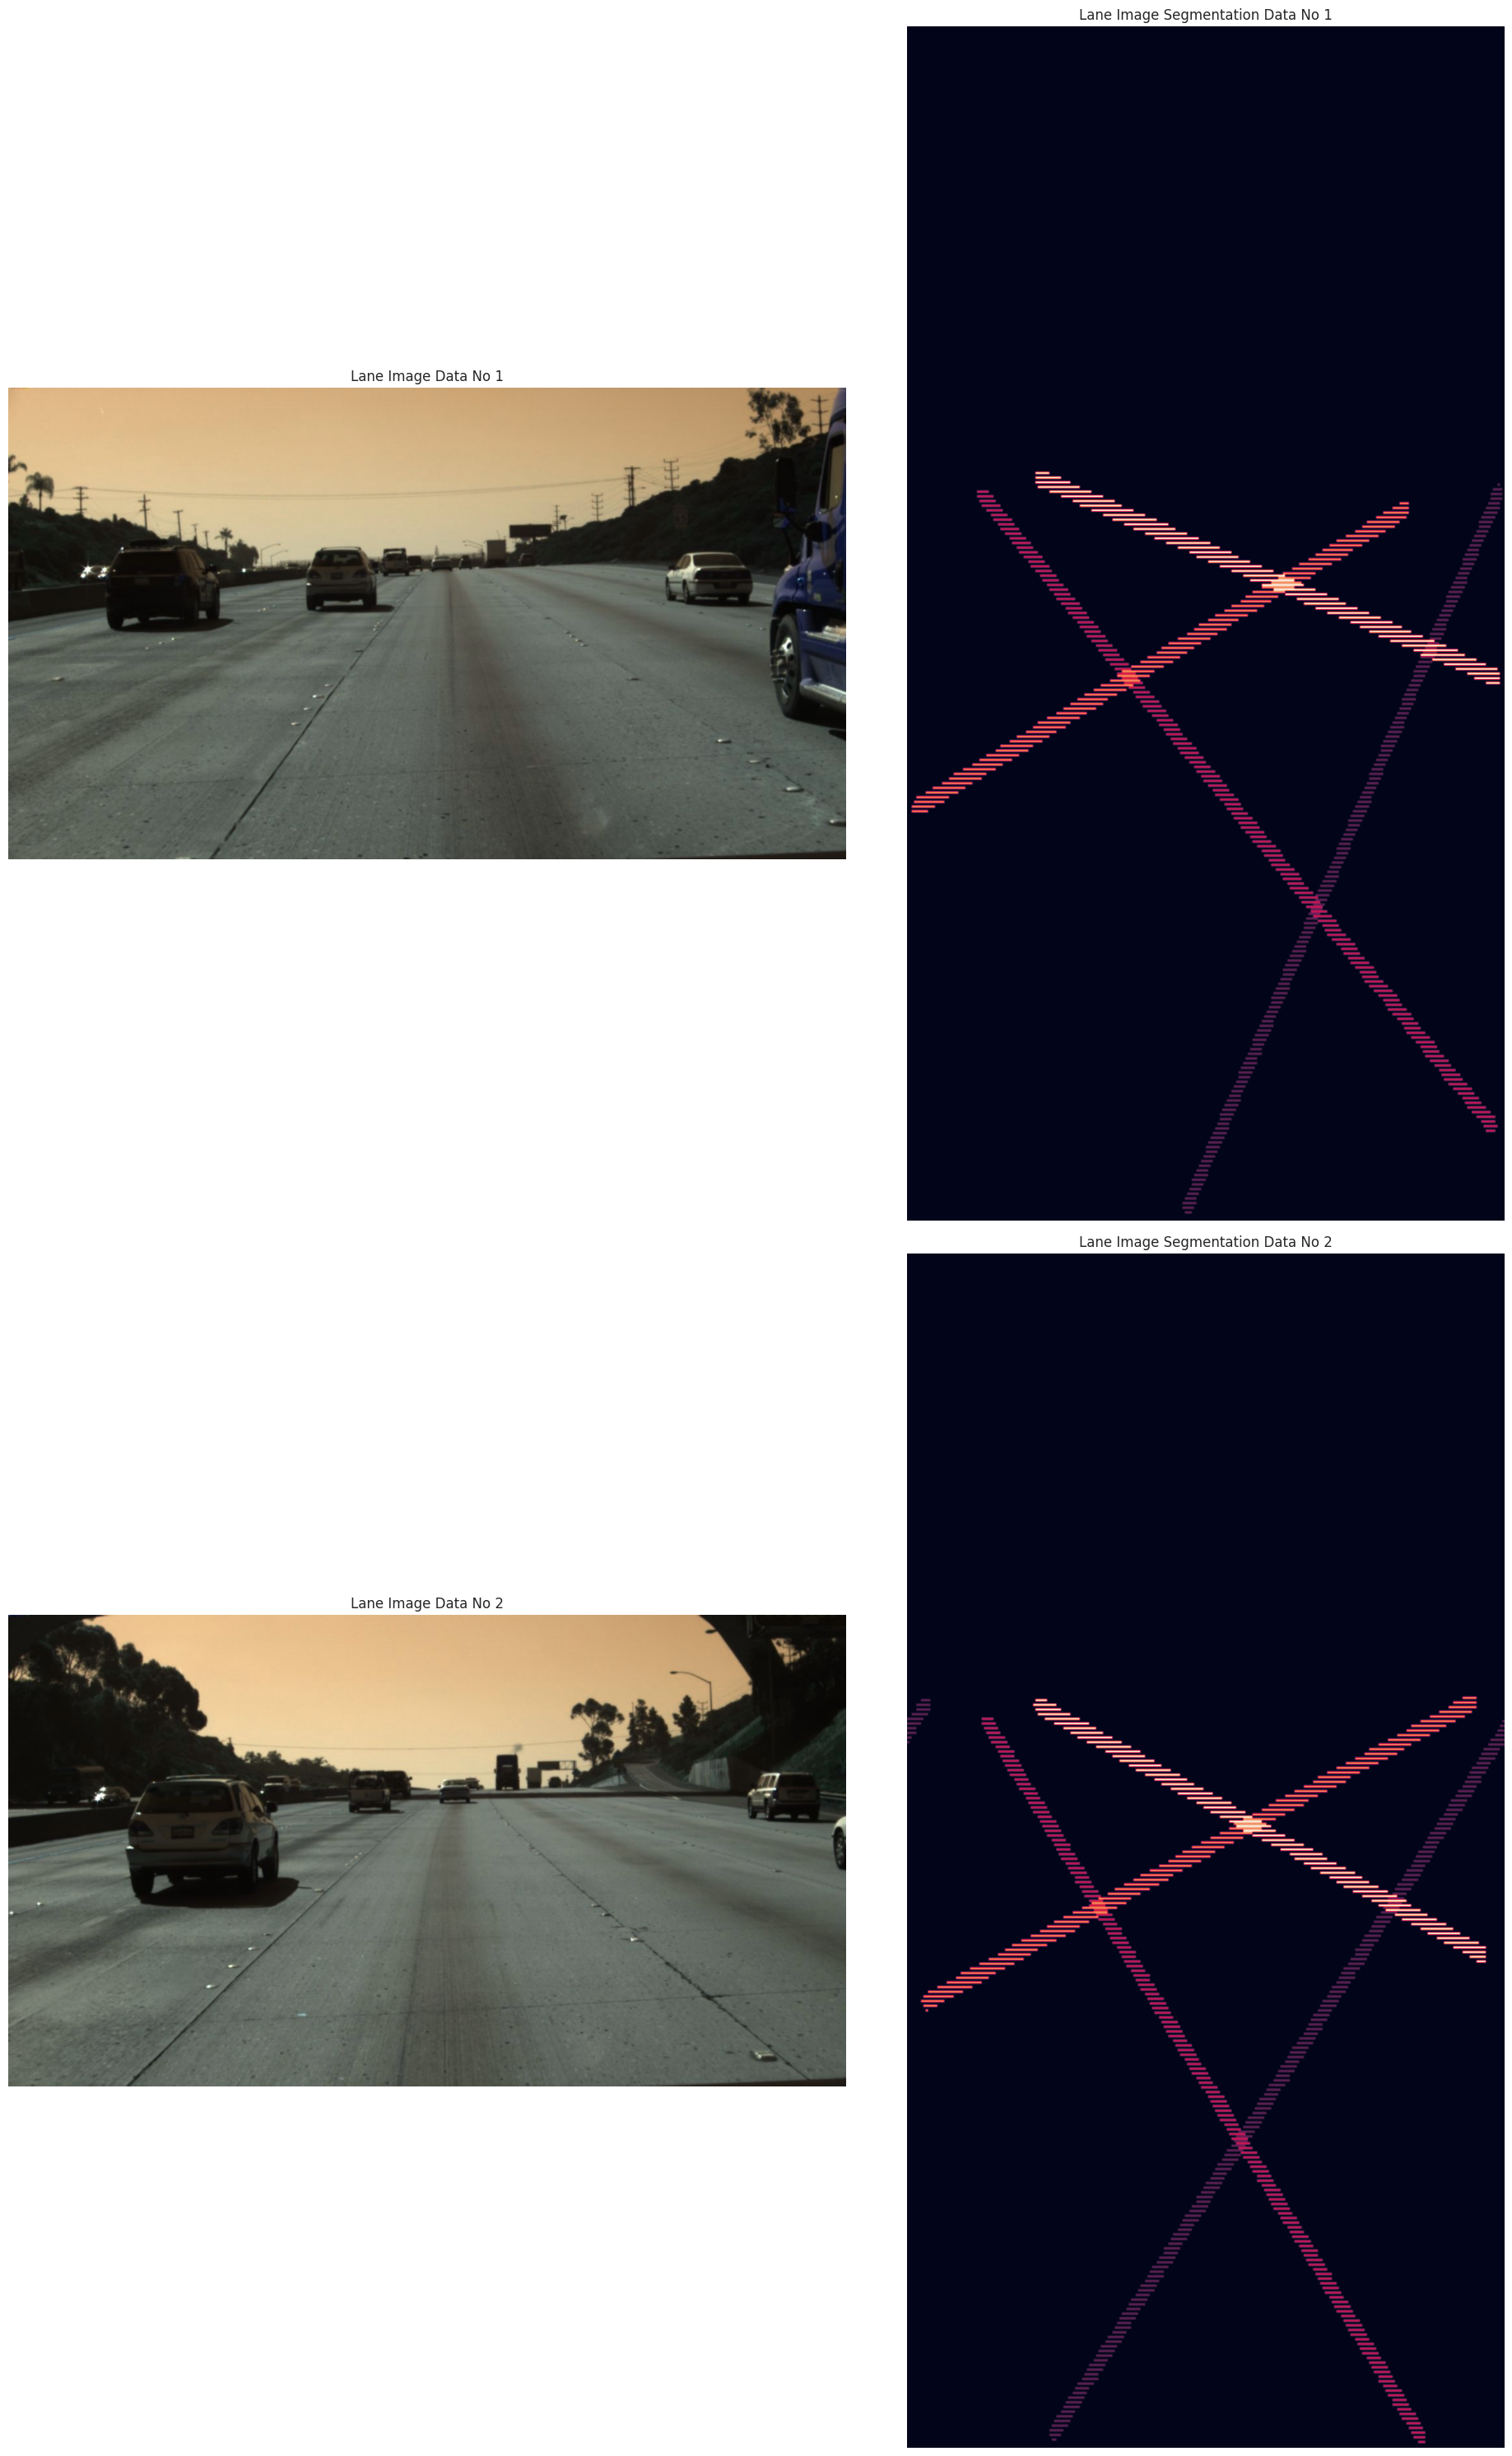

In [14]:
train_dataset._show_images_examples( number_sample= 2)

In [15]:

enet_model = UNet(2, 8)
enet_model.to(device)


params = [p for p in enet_model.parameters() if p.requires_grad]
optimizer = torch.optim.Adam(params, lr=LR, weight_decay=0.0002)


log_dir = "logs"
os.makedirs(log_dir, exist_ok=True)


writer = SummaryWriter(log_dir=log_dir)


binary_losses_epoch = []
instance_losses_epoch = []
train_accuracies = []
train_f1_score = []

# Training loop
for epoch in range(NUM_EPOCHS):
    enet_model.train()
    losses = []
    correct_binary = 0
    total_pixels = 0
    false_positive_result= 0
    true_positive_result = 0

    for batch in tqdm.tqdm(train_dataloader):
        img, binary_target, instance_target, raw_image = batch
        img = img.to(device)
        binary_target = binary_target.to(device)
        instance_target = instance_target.to(device)

        optimizer.zero_grad()

        binary_logits, instance_emb = enet_model(img)

        binary_loss, instance_loss = compute_loss(binary_logits, instance_emb, binary_target, instance_target)
        loss = binary_loss + instance_loss
        loss.backward()

        optimizer.step()

        losses.append((binary_loss.detach().cpu(), instance_loss.detach().cpu()))

        binary_preds = torch.argmax(binary_logits, dim=1)
        correct_binary += torch.sum(binary_preds == binary_target).item()

        false_positive_result += torch.sum( ( binary_preds == 1 ) & ( binary_target == 0 ) ).item()
        true_positive_result += torch.sum( (binary_preds == 1 ) & ( binary_target == 1 ) ).item()
        total_pixels += binary_target.numel()

    binary_accuracy = correct_binary / total_pixels
    binary_total_false = total_pixels - correct_binary
    binary_precision = ( true_positive_result )/ ( true_positive_result + false_positive_result )
    binary_recall = ( true_positive_result )/ ( true_positive_result + binary_total_false - false_positive_result )
    binary_f1_score = 0 if ( binary_recall == 0 ) or ( binary_precision == 0 ) else 2/ ( 1/binary_precision + 1/binary_recall )
    train_accuracies.append(binary_accuracy)
    train_f1_score.append( binary_f1_score )

    mean_losses = np.array(losses).mean(axis=0)
    binary_losses_epoch.append(mean_losses[0])
    instance_losses_epoch.append(mean_losses[1])

    # Log metrics to TensorBoard
    writer.add_scalar("Binary Loss", mean_losses[0], epoch)
    writer.add_scalar("Instance Loss", mean_losses[1], epoch)
    writer.add_scalar("Binary Accuracy", binary_accuracy, epoch)
    writer.add_scalar( "Binary F1 Score", binary_f1_score , epoch )


    # Log details of all layers in histogram format
    for name, param in enet_model.named_parameters():
        writer.add_histogram(name, param.clone().cpu().data.numpy(), global_step=epoch)

    # Print and save results for this epoch
    msg = (f"Epoch {epoch}:"
          f" Binary Loss = {mean_losses[0]:.4f}, Instance Loss = {mean_losses[1]:.4f}, Binary Accuracy = {binary_accuracy:.4f} , Binary F1- Score = {binary_f1_score:.4f}" )
    print(msg)

# Close TensorBoard writer
writer.close()

100%|██████████| 201/201 [01:54<00:00,  1.76it/s]


Epoch 0: Binary Loss = 0.3960, Instance Loss = 2.6913, Binary Accuracy = 0.8171 , Binary F1- Score = 0.0484


100%|██████████| 201/201 [01:40<00:00,  2.00it/s]


Epoch 1: Binary Loss = 0.0856, Instance Loss = 0.3543, Binary Accuracy = 0.9729 , Binary F1- Score = 0.0018


100%|██████████| 201/201 [01:40<00:00,  2.00it/s]


Epoch 2: Binary Loss = 0.0647, Instance Loss = 0.2048, Binary Accuracy = 0.9729 , Binary F1- Score = 0.0019


100%|██████████| 201/201 [01:39<00:00,  2.03it/s]


Epoch 3: Binary Loss = 0.0572, Instance Loss = 0.1446, Binary Accuracy = 0.9730 , Binary F1- Score = 0.0057


100%|██████████| 201/201 [01:37<00:00,  2.06it/s]


Epoch 4: Binary Loss = 0.0532, Instance Loss = 0.1119, Binary Accuracy = 0.9731 , Binary F1- Score = 0.0189


100%|██████████| 201/201 [01:39<00:00,  2.02it/s]


Epoch 5: Binary Loss = 0.0507, Instance Loss = 0.0951, Binary Accuracy = 0.9733 , Binary F1- Score = 0.0442


100%|██████████| 201/201 [01:39<00:00,  2.03it/s]


Epoch 6: Binary Loss = 0.0493, Instance Loss = 0.0860, Binary Accuracy = 0.9737 , Binary F1- Score = 0.0906


100%|██████████| 201/201 [01:38<00:00,  2.04it/s]


Epoch 7: Binary Loss = 0.0479, Instance Loss = 0.0729, Binary Accuracy = 0.9737 , Binary F1- Score = 0.0930


100%|██████████| 201/201 [01:39<00:00,  2.01it/s]


Epoch 8: Binary Loss = 0.0469, Instance Loss = 0.0635, Binary Accuracy = 0.9738 , Binary F1- Score = 0.0982


100%|██████████| 201/201 [01:39<00:00,  2.03it/s]


Epoch 9: Binary Loss = 0.0462, Instance Loss = 0.0603, Binary Accuracy = 0.9737 , Binary F1- Score = 0.0901


100%|██████████| 201/201 [01:37<00:00,  2.06it/s]


Epoch 10: Binary Loss = 0.0457, Instance Loss = 0.0554, Binary Accuracy = 0.9737 , Binary F1- Score = 0.0820


100%|██████████| 201/201 [01:40<00:00,  2.00it/s]


Epoch 11: Binary Loss = 0.0454, Instance Loss = 0.0555, Binary Accuracy = 0.9737 , Binary F1- Score = 0.0819


100%|██████████| 201/201 [01:38<00:00,  2.04it/s]


Epoch 12: Binary Loss = 0.0452, Instance Loss = 0.0547, Binary Accuracy = 0.9736 , Binary F1- Score = 0.0813


100%|██████████| 201/201 [01:40<00:00,  2.00it/s]


Epoch 13: Binary Loss = 0.0449, Instance Loss = 0.0476, Binary Accuracy = 0.9736 , Binary F1- Score = 0.0793


100%|██████████| 201/201 [01:37<00:00,  2.06it/s]


Epoch 14: Binary Loss = 0.0444, Instance Loss = 0.0452, Binary Accuracy = 0.9736 , Binary F1- Score = 0.0820


100%|██████████| 201/201 [01:38<00:00,  2.03it/s]


Epoch 15: Binary Loss = 0.0442, Instance Loss = 0.0421, Binary Accuracy = 0.9737 , Binary F1- Score = 0.0810


100%|██████████| 201/201 [01:40<00:00,  2.00it/s]


Epoch 16: Binary Loss = 0.0441, Instance Loss = 0.0426, Binary Accuracy = 0.9737 , Binary F1- Score = 0.0848


100%|██████████| 201/201 [01:39<00:00,  2.03it/s]


Epoch 17: Binary Loss = 0.0438, Instance Loss = 0.0388, Binary Accuracy = 0.9737 , Binary F1- Score = 0.0838


100%|██████████| 201/201 [01:41<00:00,  1.99it/s]


Epoch 18: Binary Loss = 0.0436, Instance Loss = 0.0387, Binary Accuracy = 0.9737 , Binary F1- Score = 0.0841


100%|██████████| 201/201 [01:41<00:00,  1.97it/s]


Epoch 19: Binary Loss = 0.0431, Instance Loss = 0.0350, Binary Accuracy = 0.9736 , Binary F1- Score = 0.0804


100%|██████████| 201/201 [01:40<00:00,  2.00it/s]


Epoch 20: Binary Loss = 0.0430, Instance Loss = 0.0328, Binary Accuracy = 0.9736 , Binary F1- Score = 0.0774


100%|██████████| 201/201 [01:37<00:00,  2.05it/s]


Epoch 21: Binary Loss = 0.0427, Instance Loss = 0.0339, Binary Accuracy = 0.9736 , Binary F1- Score = 0.0790


100%|██████████| 201/201 [01:39<00:00,  2.03it/s]


Epoch 22: Binary Loss = 0.0426, Instance Loss = 0.0347, Binary Accuracy = 0.9736 , Binary F1- Score = 0.0731


100%|██████████| 201/201 [01:41<00:00,  1.99it/s]


Epoch 23: Binary Loss = 0.0425, Instance Loss = 0.0322, Binary Accuracy = 0.9736 , Binary F1- Score = 0.0692


100%|██████████| 201/201 [01:42<00:00,  1.96it/s]


Epoch 24: Binary Loss = 0.0422, Instance Loss = 0.0302, Binary Accuracy = 0.9736 , Binary F1- Score = 0.0690


100%|██████████| 201/201 [01:40<00:00,  1.99it/s]


Epoch 25: Binary Loss = 0.0422, Instance Loss = 0.0285, Binary Accuracy = 0.9736 , Binary F1- Score = 0.0674


100%|██████████| 201/201 [01:39<00:00,  2.02it/s]


Epoch 26: Binary Loss = 0.0418, Instance Loss = 0.0268, Binary Accuracy = 0.9735 , Binary F1- Score = 0.0657


100%|██████████| 201/201 [01:37<00:00,  2.05it/s]


Epoch 27: Binary Loss = 0.0416, Instance Loss = 0.0261, Binary Accuracy = 0.9736 , Binary F1- Score = 0.0695


100%|██████████| 201/201 [01:39<00:00,  2.02it/s]


Epoch 28: Binary Loss = 0.0420, Instance Loss = 0.0312, Binary Accuracy = 0.9736 , Binary F1- Score = 0.0678


100%|██████████| 201/201 [01:38<00:00,  2.05it/s]


Epoch 29: Binary Loss = 0.0421, Instance Loss = 0.0321, Binary Accuracy = 0.9736 , Binary F1- Score = 0.0682


100%|██████████| 201/201 [01:37<00:00,  2.06it/s]


Epoch 30: Binary Loss = 0.0417, Instance Loss = 0.0288, Binary Accuracy = 0.9736 , Binary F1- Score = 0.0690


100%|██████████| 201/201 [01:40<00:00,  1.99it/s]


Epoch 31: Binary Loss = 0.0419, Instance Loss = 0.0310, Binary Accuracy = 0.9737 , Binary F1- Score = 0.0758


100%|██████████| 201/201 [01:43<00:00,  1.95it/s]


Epoch 32: Binary Loss = 0.0413, Instance Loss = 0.0247, Binary Accuracy = 0.9737 , Binary F1- Score = 0.0789


100%|██████████| 201/201 [01:39<00:00,  2.03it/s]


Epoch 33: Binary Loss = 0.0409, Instance Loss = 0.0229, Binary Accuracy = 0.9738 , Binary F1- Score = 0.0864


100%|██████████| 201/201 [01:36<00:00,  2.07it/s]


Epoch 34: Binary Loss = 0.0408, Instance Loss = 0.0220, Binary Accuracy = 0.9739 , Binary F1- Score = 0.0974


100%|██████████| 201/201 [01:38<00:00,  2.04it/s]


Epoch 35: Binary Loss = 0.0407, Instance Loss = 0.0223, Binary Accuracy = 0.9739 , Binary F1- Score = 0.1043


100%|██████████| 201/201 [01:37<00:00,  2.05it/s]


Epoch 36: Binary Loss = 0.0412, Instance Loss = 0.0255, Binary Accuracy = 0.9741 , Binary F1- Score = 0.1173


100%|██████████| 201/201 [01:37<00:00,  2.07it/s]


Epoch 37: Binary Loss = 0.0413, Instance Loss = 0.0271, Binary Accuracy = 0.9741 , Binary F1- Score = 0.1260


100%|██████████| 201/201 [01:39<00:00,  2.03it/s]


Epoch 38: Binary Loss = 0.0416, Instance Loss = 0.0365, Binary Accuracy = 0.9745 , Binary F1- Score = 0.1572


100%|██████████| 201/201 [01:38<00:00,  2.04it/s]


Epoch 39: Binary Loss = 0.0416, Instance Loss = 0.0314, Binary Accuracy = 0.9750 , Binary F1- Score = 0.2024


100%|██████████| 201/201 [01:37<00:00,  2.06it/s]


Epoch 40: Binary Loss = 0.0408, Instance Loss = 0.0218, Binary Accuracy = 0.9754 , Binary F1- Score = 0.2366


100%|██████████| 201/201 [01:37<00:00,  2.06it/s]


Epoch 41: Binary Loss = 0.0401, Instance Loss = 0.0177, Binary Accuracy = 0.9759 , Binary F1- Score = 0.2796


100%|██████████| 201/201 [01:38<00:00,  2.04it/s]


Epoch 42: Binary Loss = 0.0397, Instance Loss = 0.0166, Binary Accuracy = 0.9772 , Binary F1- Score = 0.3673


100%|██████████| 201/201 [01:38<00:00,  2.04it/s]


Epoch 43: Binary Loss = 0.0376, Instance Loss = 0.0182, Binary Accuracy = 0.9828 , Binary F1- Score = 0.6553


100%|██████████| 201/201 [01:37<00:00,  2.07it/s]


Epoch 44: Binary Loss = 0.0378, Instance Loss = 0.0230, Binary Accuracy = 0.9834 , Binary F1- Score = 0.6765


100%|██████████| 201/201 [01:38<00:00,  2.05it/s]


Epoch 45: Binary Loss = 0.0368, Instance Loss = 0.0175, Binary Accuracy = 0.9838 , Binary F1- Score = 0.6851


100%|██████████| 201/201 [01:37<00:00,  2.06it/s]


Epoch 46: Binary Loss = 0.0370, Instance Loss = 0.0219, Binary Accuracy = 0.9837 , Binary F1- Score = 0.6827


100%|██████████| 201/201 [01:36<00:00,  2.08it/s]


Epoch 47: Binary Loss = 0.0362, Instance Loss = 0.0185, Binary Accuracy = 0.9841 , Binary F1- Score = 0.6920


100%|██████████| 201/201 [01:38<00:00,  2.04it/s]


Epoch 48: Binary Loss = 0.0359, Instance Loss = 0.0173, Binary Accuracy = 0.9841 , Binary F1- Score = 0.6924


100%|██████████| 201/201 [01:38<00:00,  2.05it/s]


Epoch 49: Binary Loss = 0.0354, Instance Loss = 0.0143, Binary Accuracy = 0.9844 , Binary F1- Score = 0.6982


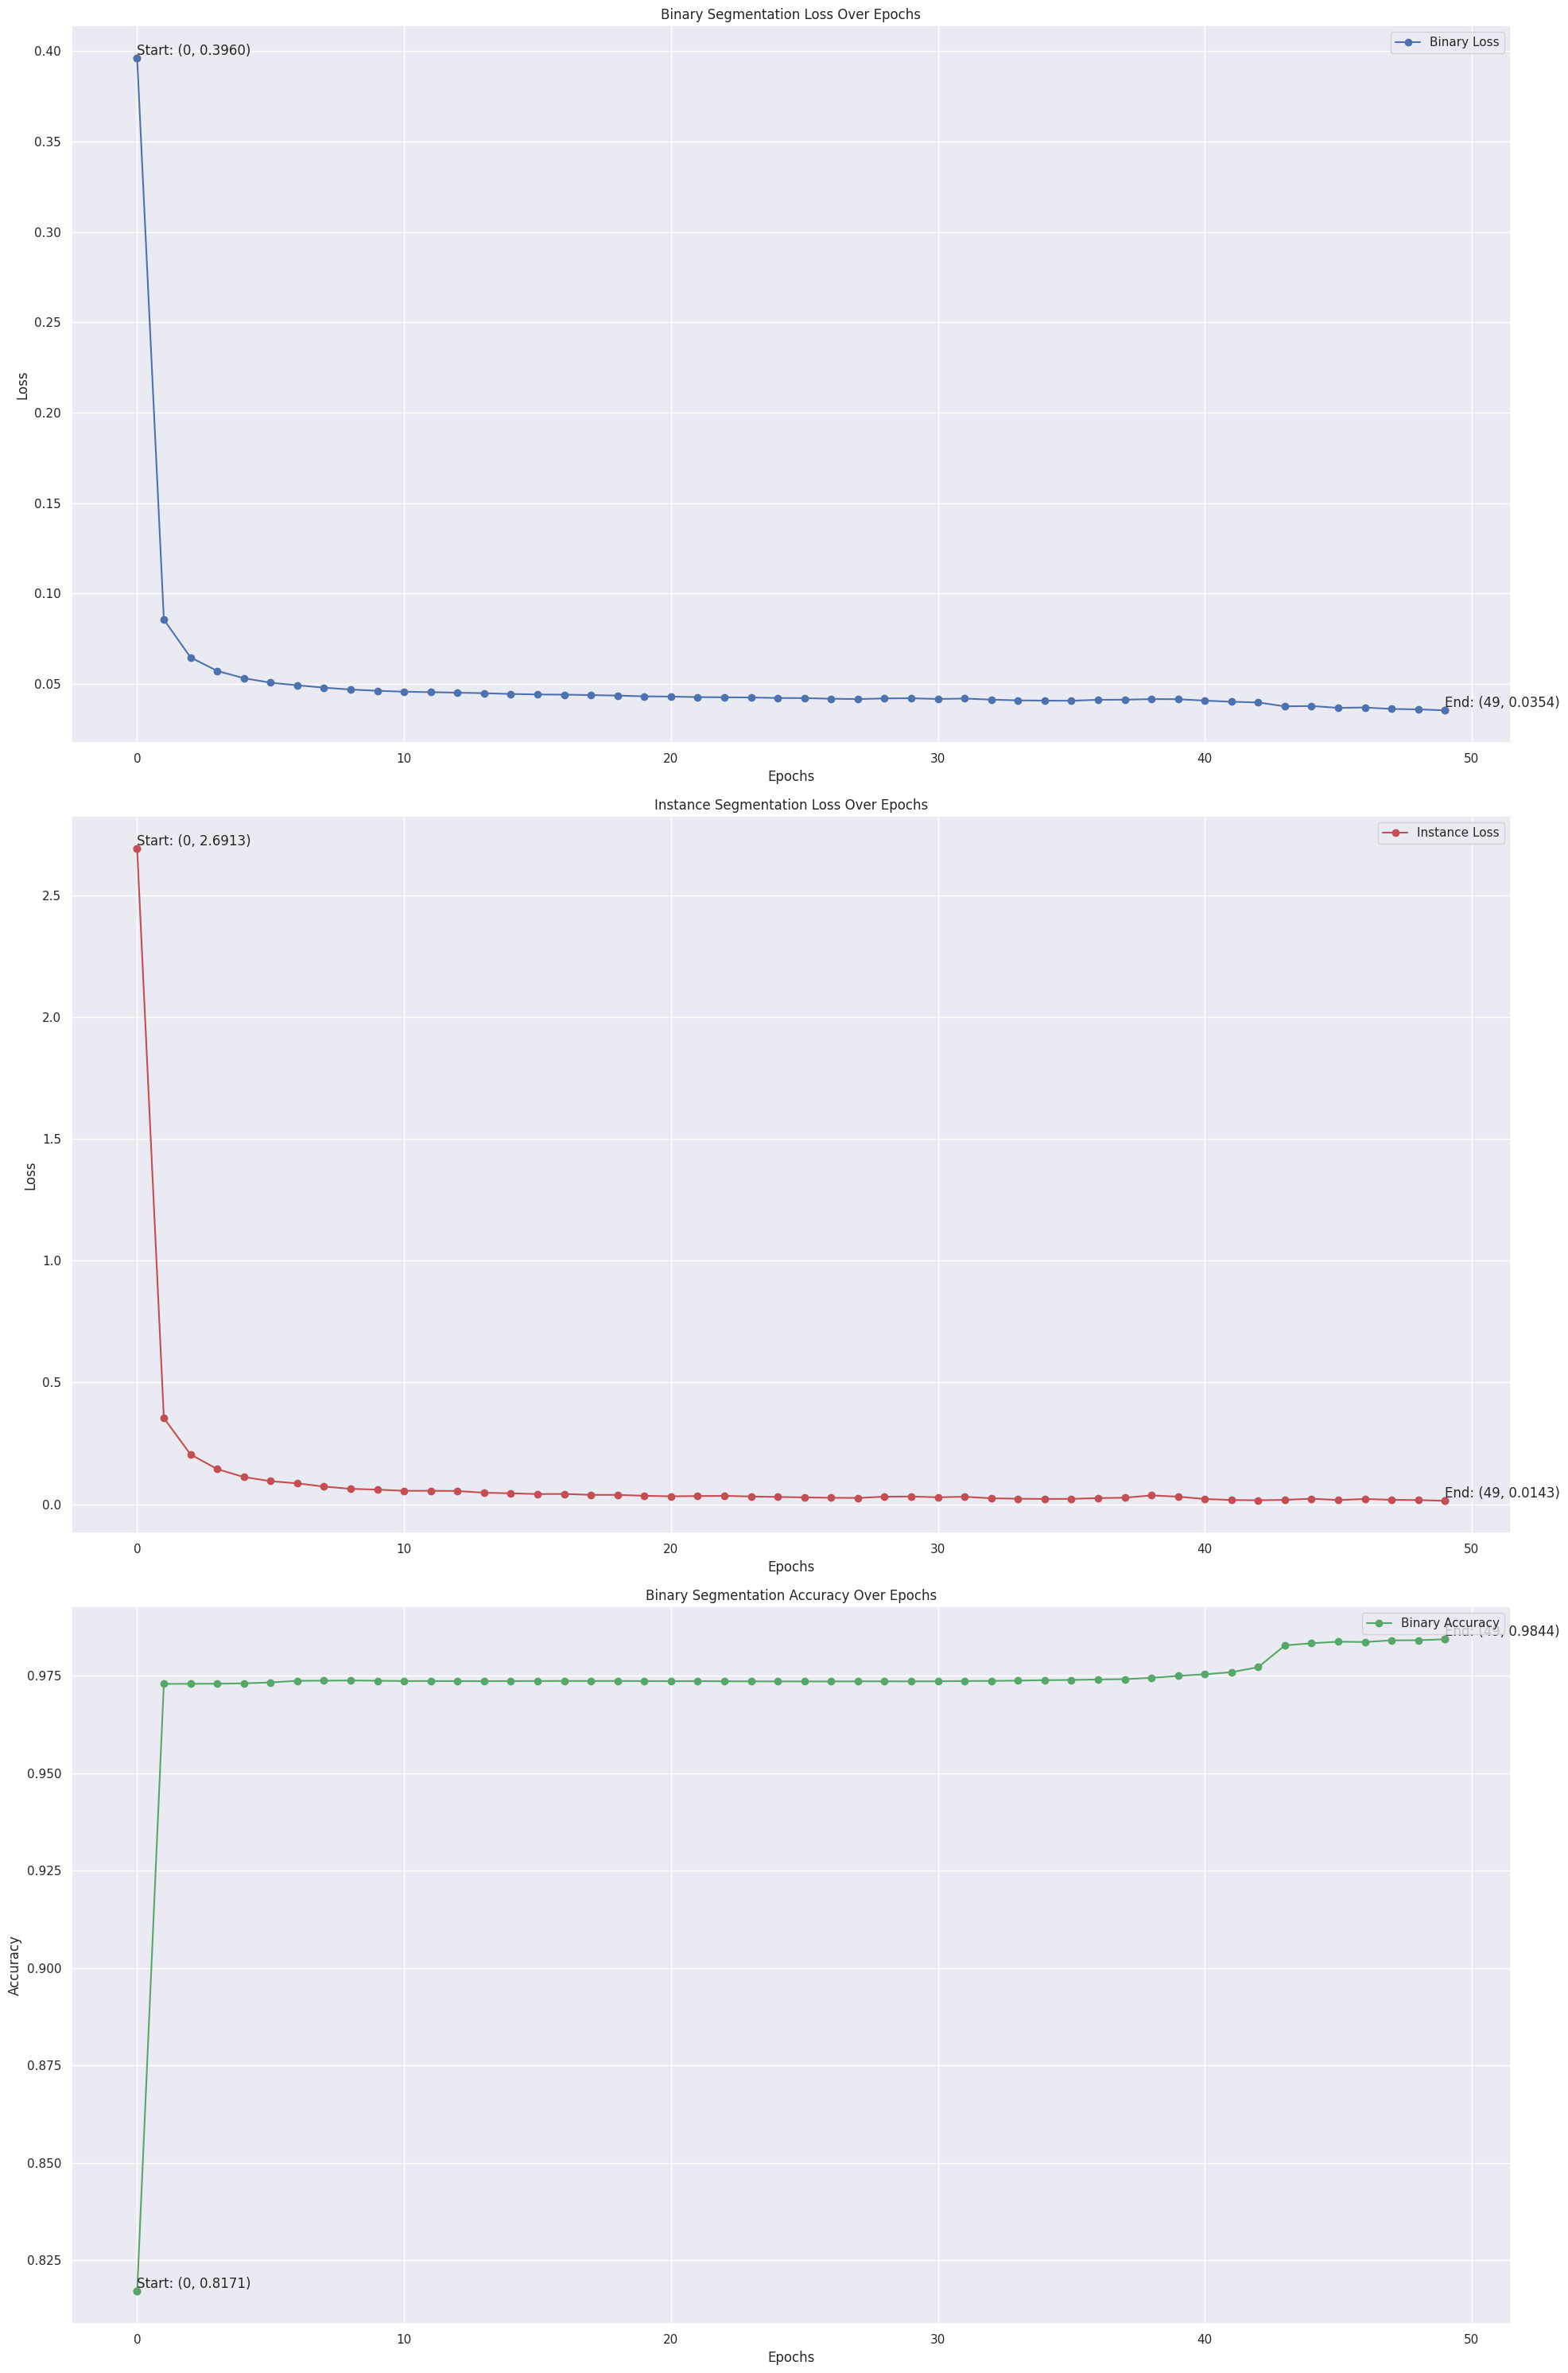

In [16]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import tqdm


plt.figure(figsize=(20, 30))

# Plot Binary Segmentation Loss
plt.subplot(3, 1, 1)
plt.plot(range(NUM_EPOCHS), binary_losses_epoch, label="Binary Loss", color='b', marker='o')
plt.scatter([0, NUM_EPOCHS - 1], [binary_losses_epoch[0], binary_losses_epoch[-1]], color='r', marker='o')
plt.text(0, binary_losses_epoch[0], f'Start: (0, {binary_losses_epoch[0]:.4f})', verticalalignment='bottom')
plt.text(NUM_EPOCHS - 1, binary_losses_epoch[-1], f'End: ({NUM_EPOCHS - 1}, {binary_losses_epoch[-1]:.4f})', verticalalignment='bottom')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Binary Segmentation Loss Over Epochs')
plt.legend()

# Plot Instance Segmentation Loss
plt.subplot(3, 1, 2)
plt.plot(range(NUM_EPOCHS), instance_losses_epoch, label="Instance Loss", color='r', marker='o')
plt.scatter([0, NUM_EPOCHS - 1], [instance_losses_epoch[0], instance_losses_epoch[-1]], color='r', marker='o')
plt.text(0, instance_losses_epoch[0], f'Start: (0, {instance_losses_epoch[0]:.4f})', verticalalignment='bottom')
plt.text(NUM_EPOCHS - 1, instance_losses_epoch[-1], f'End: ({NUM_EPOCHS - 1}, {instance_losses_epoch[-1]:.4f})', verticalalignment='bottom')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Instance Segmentation Loss Over Epochs')
plt.legend()

# Plot Binary Segmentation Accuracy
plt.subplot(3, 1, 3)
plt.plot(range(NUM_EPOCHS), train_accuracies, label="Binary Accuracy", color='g', marker='o')
plt.scatter([0, NUM_EPOCHS - 1], [train_accuracies[0], train_accuracies[-1]], color='r', marker='o')
plt.text(0, train_accuracies[0], f'Start: (0, {train_accuracies[0]:.4f})', verticalalignment='bottom')
plt.text(NUM_EPOCHS - 1, train_accuracies[-1], f'End: ({NUM_EPOCHS - 1}, {train_accuracies[-1]:.4f})', verticalalignment='bottom')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Binary Segmentation Accuracy Over Epochs')
plt.legend()

plt.tight_layout()
plt.savefig("combined_plots_with_start_end_values_on_marker.png")
plt.show()

In [17]:
# Save the trained model
torch.save(enet_model.state_dict(), "model.p")

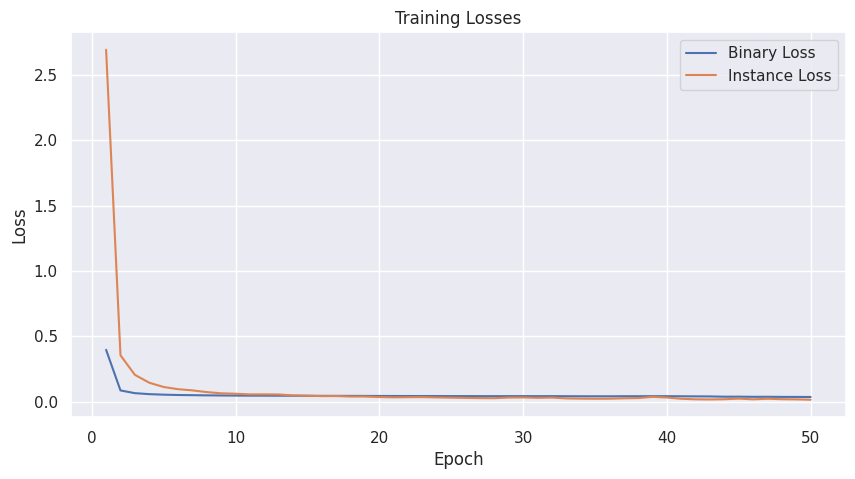

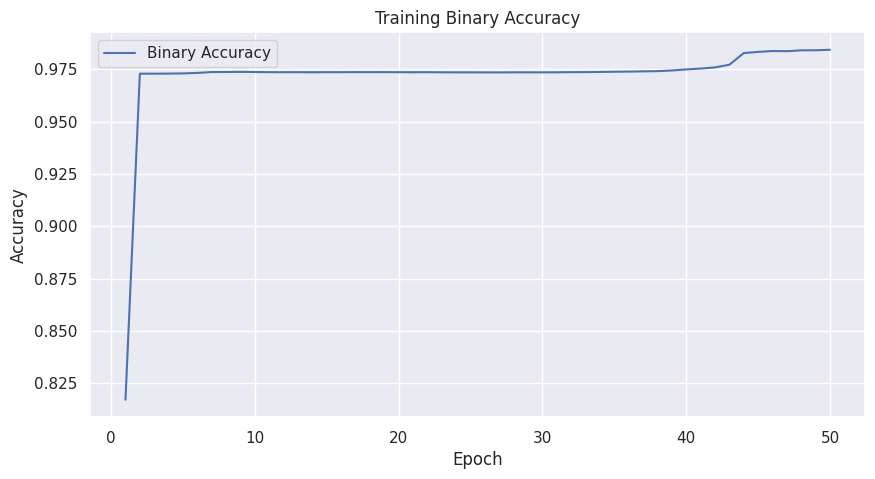

In [18]:
# Plotting training losses
plt.figure(figsize=(10, 5))
plt.plot(range(1, NUM_EPOCHS + 1), binary_losses_epoch, label='Binary Loss')
plt.plot(range(1, NUM_EPOCHS + 1), instance_losses_epoch, label='Instance Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Losses')
plt.legend()
plt.show()

# Plotting training accuracy
plt.figure(figsize=(10, 5))
plt.plot(range(1, NUM_EPOCHS + 1), train_accuracies, label='Binary Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training Binary Accuracy')
plt.legend()
plt.show()